In [ ]:
#LIGHTGMB - tuning hiperparametrów i tresholda

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import f_oneway, chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
np.random.seed = 42

df = pd.read_csv('learning_set.csv')
df.head()

# Zakładamy, że kolumna celu nazywa się:
target_column = 'Lung_Cancer_Diagnosis'

X = df.drop(columns=[target_column])
y = df[target_column]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,        # zachowujemy proporcje klas!
    random_state=42
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Train class distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test class distribution:\n{y_test.value_counts(normalize=True)}")


c:\Users\66891\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Train size: (149600, 17), Test size: (64115, 17)
Train class distribution:
Lung_Cancer_Diagnosis
0    0.960401
1    0.039599
Name: proportion, dtype: float64
Test class distribution:
Lung_Cancer_Diagnosis
0    0.960399
1    0.039601
Name: proportion, dtype: float64


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import GridSearchCV

# Bazowy model
lgbm = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Param grid — nie za szeroki, ale z szansą na lepszy wynik
param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, -1],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20],
    'subsample': [0.8, 1.0],
}

grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='average_precision',  # lub f1, jeśli wolisz
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)


best_model = grid.best_estimator_
y_probs = best_model.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

best_threshold = thresholds[np.argmax(f1_scores[:-1])]
print(f"🧠 Najlepszy threshold (dla max F1): {best_threshold:.3f}")


y_pred_custom = (y_probs >= best_threshold).astype(int)
print("\n📊 Classification Report (custom threshold):")
print(classification_report(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred_custom)
print("\n🔍 Confusion Matrix:")
print(cm)
print("🎯 Najlepsze parametry:", grid.best_params_)



Fitting 3 folds for each of 216 candidates, totalling 648 fits
[LightGBM] [Info] Number of positive: 5924, number of negative: 143676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 149600, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

📊 Classification Report (custom threshold):
              precision    recall  f1-score   support

           0       0.98      0.66      0.79     61576
           1       0.07      0.64      0.13      2539

    accuracy                           0.66     64115
   macro avg       0.52      0.65      0.46     64115
weighted avg       0.94      0.66      0.76     64115


🔍 Confu

In [ ]:
print("🎯 Najlepsze parametry:", grid.best_params_)


🎯 Najlepsze parametry: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 15, 'subsample': 0.8}


In [ ]:
"""
🔧 Jak działa LightGBM?
Podstawowy mechanizm to boosting:

Tworzymy pierwszy drzewo (drzewo decyzyjne), które stara się dopasować dane.

Liczymy błędy (residua) predykcji z poprzedniego modelu.

Kolejne drzewo stara się poprawić to, co poprzednie zrobiło źle.

Powtarzamy to wiele razy, a finalna predykcja to waga sumaryczna wszystkich drzew.

📌 To jest tzw. additive model, czyli uczymy się krok po kroku lepszego rozwiązania.

🔥 Czym LightGBM różni się od klasycznego Gradient Boostingu?
Tu LightGBM błyszczy dzięki dwóm technikom:

1. Histogram-based binning
Zamiast sprawdzać każdy możliwy punkt podziału dla każdego feature'a (jak np. XGBoost), LightGBM:

przekształca dane w biny (koszyki),

dzięki czemu redukuje czas i pamięć, a także nie traci wiele na dokładności.

2. Leaf-wise tree growth (z ograniczeniem depth)
Standardowo drzewa rosną poziomami (level-wise):

najpierw korzeń, potem poziom niżej itd.

LightGBM rośnie leaf-wise:

zawsze rozwija ten liść, który maksymalnie zmniejszy loss, co często daje bardziej precyzyjne dopasowanie.

➡️ Dlatego LGBM lepiej generalizuje i szybciej osiąga niski błąd niż klasyczne metody.

"""

In [ ]:
#DRUGI ZESTAW HIPERPARAMETRÓW - LICZY SIĘ BARDZO DŁUGO - robic optuną (na dole)

In [18]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import GridSearchCV

# Bazowy model
lgbm = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Param grid — nie za szeroki, ale z szansą na lepszy wynik
param_grid = {
    'learning_rate': [ 0.05, 0.1],
    'max_depth': [5,  7],
    'min_child_samples': [10, 20],
    'n_estimators': [100, 200],
    'num_leaves': [15,  63],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],       # NOWOŚĆ — losowy wybór kolumn
    'reg_alpha': [0, 0.1, 1],                  # NOWOŚĆ — L1 regularization
    'reg_lambda': [0, 0.1, 1],
     'is_unbalance': [True]                                   # NOWOŚĆ — L2 regularization
}


grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='average_precision',  # lub f1, jeśli wolisz
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)


best_model = grid.best_estimator_
y_probs = best_model.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

best_threshold = thresholds[np.argmax(f1_scores[:-1])]
print(f"🧠 Najlepszy threshold (dla max F1): {best_threshold:.3f}")


y_pred_custom = (y_probs >= best_threshold).astype(int)
print("\n📊 Classification Report (custom threshold):")
print(classification_report(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred_custom)
print("\n🔍 Confusion Matrix:")
print(cm)


Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


KeyboardInterrupt: 

In [ ]:
#TUTAJ SPRÓBOWAĆ OPTUNE

In [ ]:
#!pip install Optuna

  Obtaining dependency information for Optuna from https://files.pythonhosted.org/packages/d9/dd/0b593d1a5ee431b33a1fdf4ddb5911c312ed3bb598ef9e17457af2ee7b34/optuna-4.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/41/18/d89a443ed1ab9bcda16264716f809c663866d4ca8de218aa78fd50b38ead/alembic-1.15.2-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/e3/51/9b208e85196941db2f0654ad0357ca6388ab3ed67efdbfc799f35d1f83aa/colorlog-6.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for Mako from https://files.pythonhosted.org/packages/87/fb/99f81ac72ae23375f22b7afdb7642aba97c00a713c217124420147681a2f/mako-1.3.10-py3-none-any.whl.metadata
  Obtaining dependency information for typing-extensions>=4.12 from https://files.pythonhosted.org/packages/8b/54/b1ae86c0973cc6f0210b53d508ca3641fb6d0c56823f288d108bc7ab3cc8/typing_extensions-4.13.2-p

In [2]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Przygotuj dane
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'is_unbalance': True,  # <-- bardzo ważne!
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }

    model = lgb.LGBMClassifier(**param)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]

    # użyj niestandardowego threshold (np. 0.57)
    y_pred = (y_pred_proba > 0.57).astype(int)

    return f1_score(y_valid, y_pred, average='binary')  # lub 'macro'

# Uruchom Optunę
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)  # Zmieniasz na więcej prób, jeśli masz czas
"""
# Najlepsze parametry:
print("Best params:", study.best_params)
best_model = lgb.LGBMClassifier(study.best_params)
best_model.fit(X_train, y_train)

y_probs = best_model.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

best_threshold = thresholds[np.argmax(f1_scores[:-1])]
print(f"🧠 Najlepszy threshold (dla max F1): {best_threshold:.3f}")


y_pred_custom = (y_probs >= best_threshold).astype(int)
print("\n📊 Classification Report (custom threshold):")
print(classification_report(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred_custom)
print("\n🔍 Confusion Matrix:")
print(cm)
"""

[I 2025-04-22 00:06:26,905] A new study created in memory with name: no-name-6fa1498b-9808-4509-b879-c96022ac5d11
[I 2025-04-22 00:06:29,298] Trial 0 finished with value: 0.12531527943714324 and parameters: {'learning_rate': 0.022275915090890885, 'max_depth': 10, 'num_leaves': 41, 'min_child_samples': 32, 'n_estimators': 231, 'subsample': 0.9514675358953324, 'colsample_bytree': 0.6073621902206802, 'reg_alpha': 0.043901839229258055, 'reg_lambda': 0.601650237931266}. Best is trial 0 with value: 0.12531527943714324.
[I 2025-04-22 00:06:30,152] Trial 1 finished with value: 0.12585263934124008 and parameters: {'learning_rate': 0.08201112485555904, 'max_depth': 4, 'num_leaves': 33, 'min_child_samples': 45, 'n_estimators': 129, 'subsample': 0.8084337261117092, 'colsample_bytree': 0.8611425991389552, 'reg_alpha': 0.17829781511711007, 'reg_lambda': 0.3694877688047504}. Best is trial 1 with value: 0.12585263934124008.
[I 2025-04-22 00:06:31,060] Trial 2 finished with value: 0.12331485663450352 a

'\n# Najlepsze parametry:\nprint("Best params:", study.best_params)\nbest_model = lgb.LGBMClassifier(study.best_params)\nbest_model.fit(X_train, y_train)\n\ny_probs = best_model.predict_proba(X_test)[:, 1]\n\nprecisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)\nf1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)\n\nbest_threshold = thresholds[np.argmax(f1_scores[:-1])]\nprint(f"🧠 Najlepszy threshold (dla max F1): {best_threshold:.3f}")\n\n\ny_pred_custom = (y_probs >= best_threshold).astype(int)\nprint("\n📊 Classification Report (custom threshold):")\nprint(classification_report(y_test, y_pred_custom))\n\ncm = confusion_matrix(y_test, y_pred_custom)\nprint("\n🔍 Confusion Matrix:")\nprint(cm)\n'


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.65      0.78     61576
           1       0.07      0.66      0.13      2539

    accuracy                           0.65     64115
   macro avg       0.53      0.66      0.45     64115
weighted avg       0.94      0.65      0.75     64115


🔍 Confusion Matrix:
[[39760 21816]
 [  852  1687]]

🏁 ROC AUC Score: 0.6747


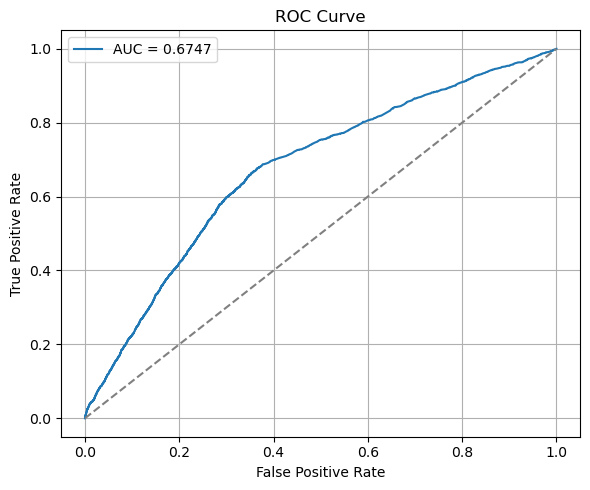

In [3]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt

# Wstaw tutaj dane podzielone wcześniej na treningowe i testowe
# X_train, X_test, y_train, y_test
params = study.best_params
best_params = {**params,
    'is_unbalance': True,  # pamiętaj o tym!
    'random_state': 42
}

model = LGBMClassifier(**best_params)
model.fit(X_train, y_train)

# Predykcje i klasy
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)  # lub inny próg, jeśli chcesz

# Raport klasyfikacji i macierz pomyłek
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# AUC
auc_score = roc_auc_score(y_test, y_proba)
print(f"\n🏁 ROC AUC Score: {auc_score:.4f}")

# Krzywa ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [4]:
import pickle
def save_model(model, path):
    with open(path, 'wb') as f:
        pickle.dump(model, f)

save_model(model, "models/lightgmb.pkl")